<a href="https://colab.research.google.com/github/lucastanger/realestate_investment_analysis/blob/main/realestate_investment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Prüfungsleistung

*   MatNr: 7474265
*   MatNr: 2923947



In [ ]:
# Necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib

%matplotlib inline

sns.set_style("dark")

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
#####################################
# Settings
# Change settings for vizualisation of outlier detection and backward elimination
remove_outliers_automatically = True
remove_outliers_threshold = 3 #### Angabe in Prozent ####
activate_backward_elimination = True
#####################################

# Receive data from url

Dataset avaiable from https://gist.githubusercontent.com/lucastanger/18f14f8acb958babdeae52956b903d75/raw/f3456ed3270c68a3260e1095f13f66cac26fba8f/realestate_investment_analysis.csv


## Technische Anforderungen: Hier kann auch eine andere Datei eingespielt werden, solange die Featurenamen übereinstimmen

In [ ]:
# Read CSV Data

data = pd.read_csv('https://gist.githubusercontent.com/lucastanger/18f14f8acb958babdeae52956b903d75/raw/f3456ed3270c68a3260e1095f13f66cac26fba8f/realestate_investment_analysis.csv', sep=',', encoding="iso-8859-1") # Latin Encoding

# CHANGE IF LOCAL FILE IS NEEDED
# data = pd.read_csv('Data.csv', sep=';', encoding="iso-8859-1")

In [ ]:
# Initial data overview
# N = 2000 => datapoints (rows)
# p = 28 => dimensions (cols)

# Goal: Forecast of valuable real estate investments
data.head(3)

,Grundstueck in qm,Grundstuecksform,Steigung,Bezirk,Zone,Lage,Typ,Zustand,Gebaut,Renoviert,Zustand Fassade,Kellerflaeche in qm,Heizung,Heizungsqualitaet,Klimaanlage,Erster Stock in qm,Zweiter Stock in qm,Wohnflaeche in qm,Schlafzimmer,Kuechen,Kuechenqualitaet,Raeume,Garage Typ,Garagenkapazitaet,Pool,Verkaufsmonat,Verkaufsjahr,Preis
0,898,IR1,Nein,Somerset,RL,Norm,2Fam,4,2107,2107,3,183,GasA,Ty,Y,183,0,183,6,2,3,10,Anbau,2,NaN,8,2136,156500
1,1326,Reg,Nein,North East,RL,Norm,1Fam,5,2133,2133,3,122,GasA,Ex,Y,113,109,222,3,1,4,7,Anbau,3,NaN,1,2137,350000
2,725,Reg,Nein,Somerset,RL,Norm,1Fam,7,2096,2138,3,80,GasA,Ex,Y,83,0,83,3,1,4,5,Freistehend,1,NaN,6,2140,137900


Einfache Analyse mit Hilfe von `data.describe()` aller verfügbaren *numerischen* Features zu Beginn der Untersuchung. 

**`count`** Anzahl vorhandener Datenpunkte **N** <br>
**`mean`** Mittelwert vorhandener Datenpunkte **N** in angegebener Dimension **p** <br>
**`std`** Standard Abweichung <br>
**`min`** Minimum <br>
**`25%`** 25% Perzentil<br>
**`50%`** 50% Perzentil<br>
**`75%`** 75% Perzentil<br>
**`max`** Maximum <br>

In [ ]:
data.describe()

,Grundstueck in qm,Zustand,Gebaut,Renoviert,Zustand Fassade,Kellerflaeche in qm,Erster Stock in qm,Zweiter Stock in qm,Wohnflaeche in qm,Schlafzimmer,Kuechen,Kuechenqualitaet,Raeume,Garagenkapazitaet,Pool,Verkaufsmonat,Verkaufsjahr,Preis
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,9.000000,2000.000000,2000.000000,2000.000000
mean,950.054000,5.697500,2099.031000,2113.344500,3.102500,96.140500,106.48100,31.125000,137.990000,2.883000,1.042000,3.456500,6.405000,1.735500,2.444444,6.102500,2137.856500,176791.811500
std,737.437654,1.129439,29.120114,20.168198,0.386094,38.249893,34.40918,39.461551,45.565953,0.817095,0.203117,0.632699,1.523856,0.736757,1.130388,2.628773,1.304131,72060.407925
min,121.000000,1.000000,2005.000000,2080.000000,1.000000,0.000000,31.00000,0.000000,31.000000,0.000000,1.000000,2.000000,2.000000,0.000000,1.000000,1.000000,2136.000000,39300.000000
25%,701.750000,5.000000,2083.000000,2095.000000,3.000000,74.000000,82.00000,0.000000,102.000000,2.000000,1.000000,3.000000,5.000000,1.000000,2.000000,4.000000,2137.000000,130000.000000
50%,887.000000,5.000000,2101.000000,2121.000000,3.000000,91.000000,99.00000,0.000000,133.000000,3.000000,1.000000,3.000000,6.000000,2.000000,2.000000,6.000000,2138.000000,158225.000000
75%,1078.000000,6.000000,2126.000000,2132.000000,3.000000,117.000000,126.00000,65.000000,161.000000,3.000000,1.000000,4.000000,7.000000,2.000000,3.000000,7.000000,2139.000000,207000.000000
max,19997.000000,9.000000,2140.000000,2140.000000,5.000000,298.000000,355.00000,174.000000,401.000000,6.000000,3.000000,5.000000,13.000000,4.000000,4.000000,12.000000,2140.000000,755000.000000


# Data Exploration und Analyse

## 1. Unique value count

Durch folgendes Diagramm kann eingesehen werden, wie viele möglichen Werte innerhalb der einzelnen Featurespalten existieren. Mit dem gegebenen Datensatz liegt das Feature **Bezirk** mit 25 individuellen Werten mit Abstand vorn. Platz 2 belegen die Features Verkaufsmonat (**12**) und Räume (**12**). 

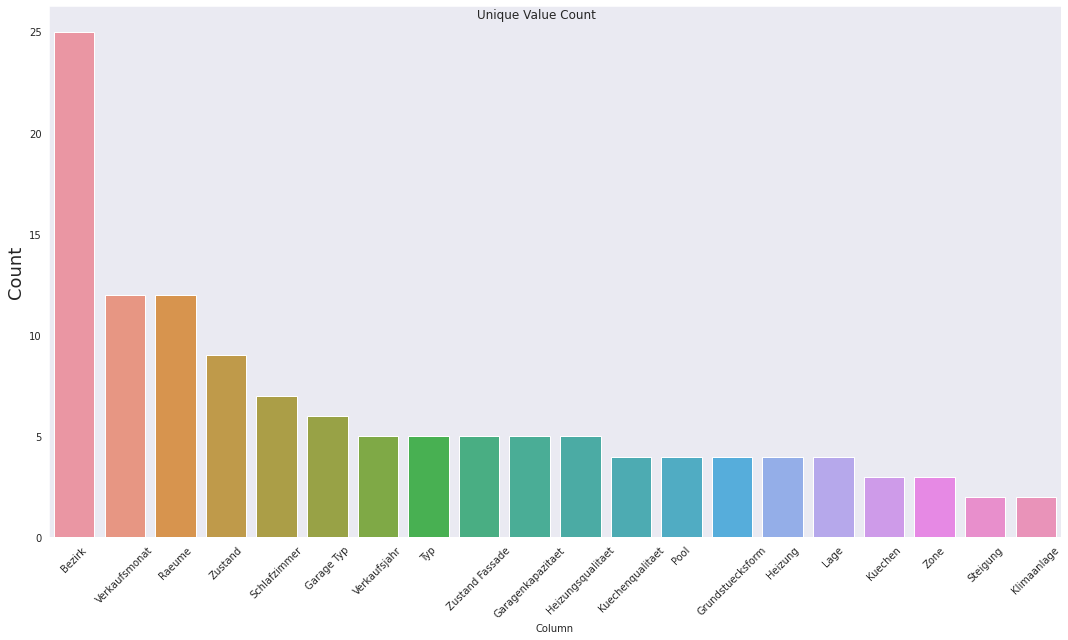

In [ ]:
unique_value_count = {'Column': [],'UniqueValues': []}

for col in data:
  unique_value_count['Column'].append(col)
  unique_value_count['UniqueValues'].append(data[col].nunique())

# Prepare dataframe
df = pd.DataFrame().from_dict(unique_value_count)
# Drop very high values
df = df.drop([0, 8, 9, 11, 15, 16, 17, 27])

fig = plt.figure(figsize=(15,9))
fig.suptitle('Unique Value Count')
sns.barplot(x='Column', y='UniqueValues', data=df, order=df.sort_values('UniqueValues', ascending=False).Column)
# set labels
plt.ylabel('Count', size=18)
plt.xticks(rotation=45)
plt.tight_layout()

## 2. Frequency Count

Mit Hilfe der Frequency Count (*Frequenzzählung*) lässt sich veranschaulichen, wie sehr die Werte innerhalb der Featurespalten verteilt sind. Auffallend hierbei sind Features, welche > 80% der Daten in einer einzelnen Klasse besitzen. Der Einfluss dieser Features auf das Regressionsergebnis wird in den folgenden Kapitel weitergehend analysiert.

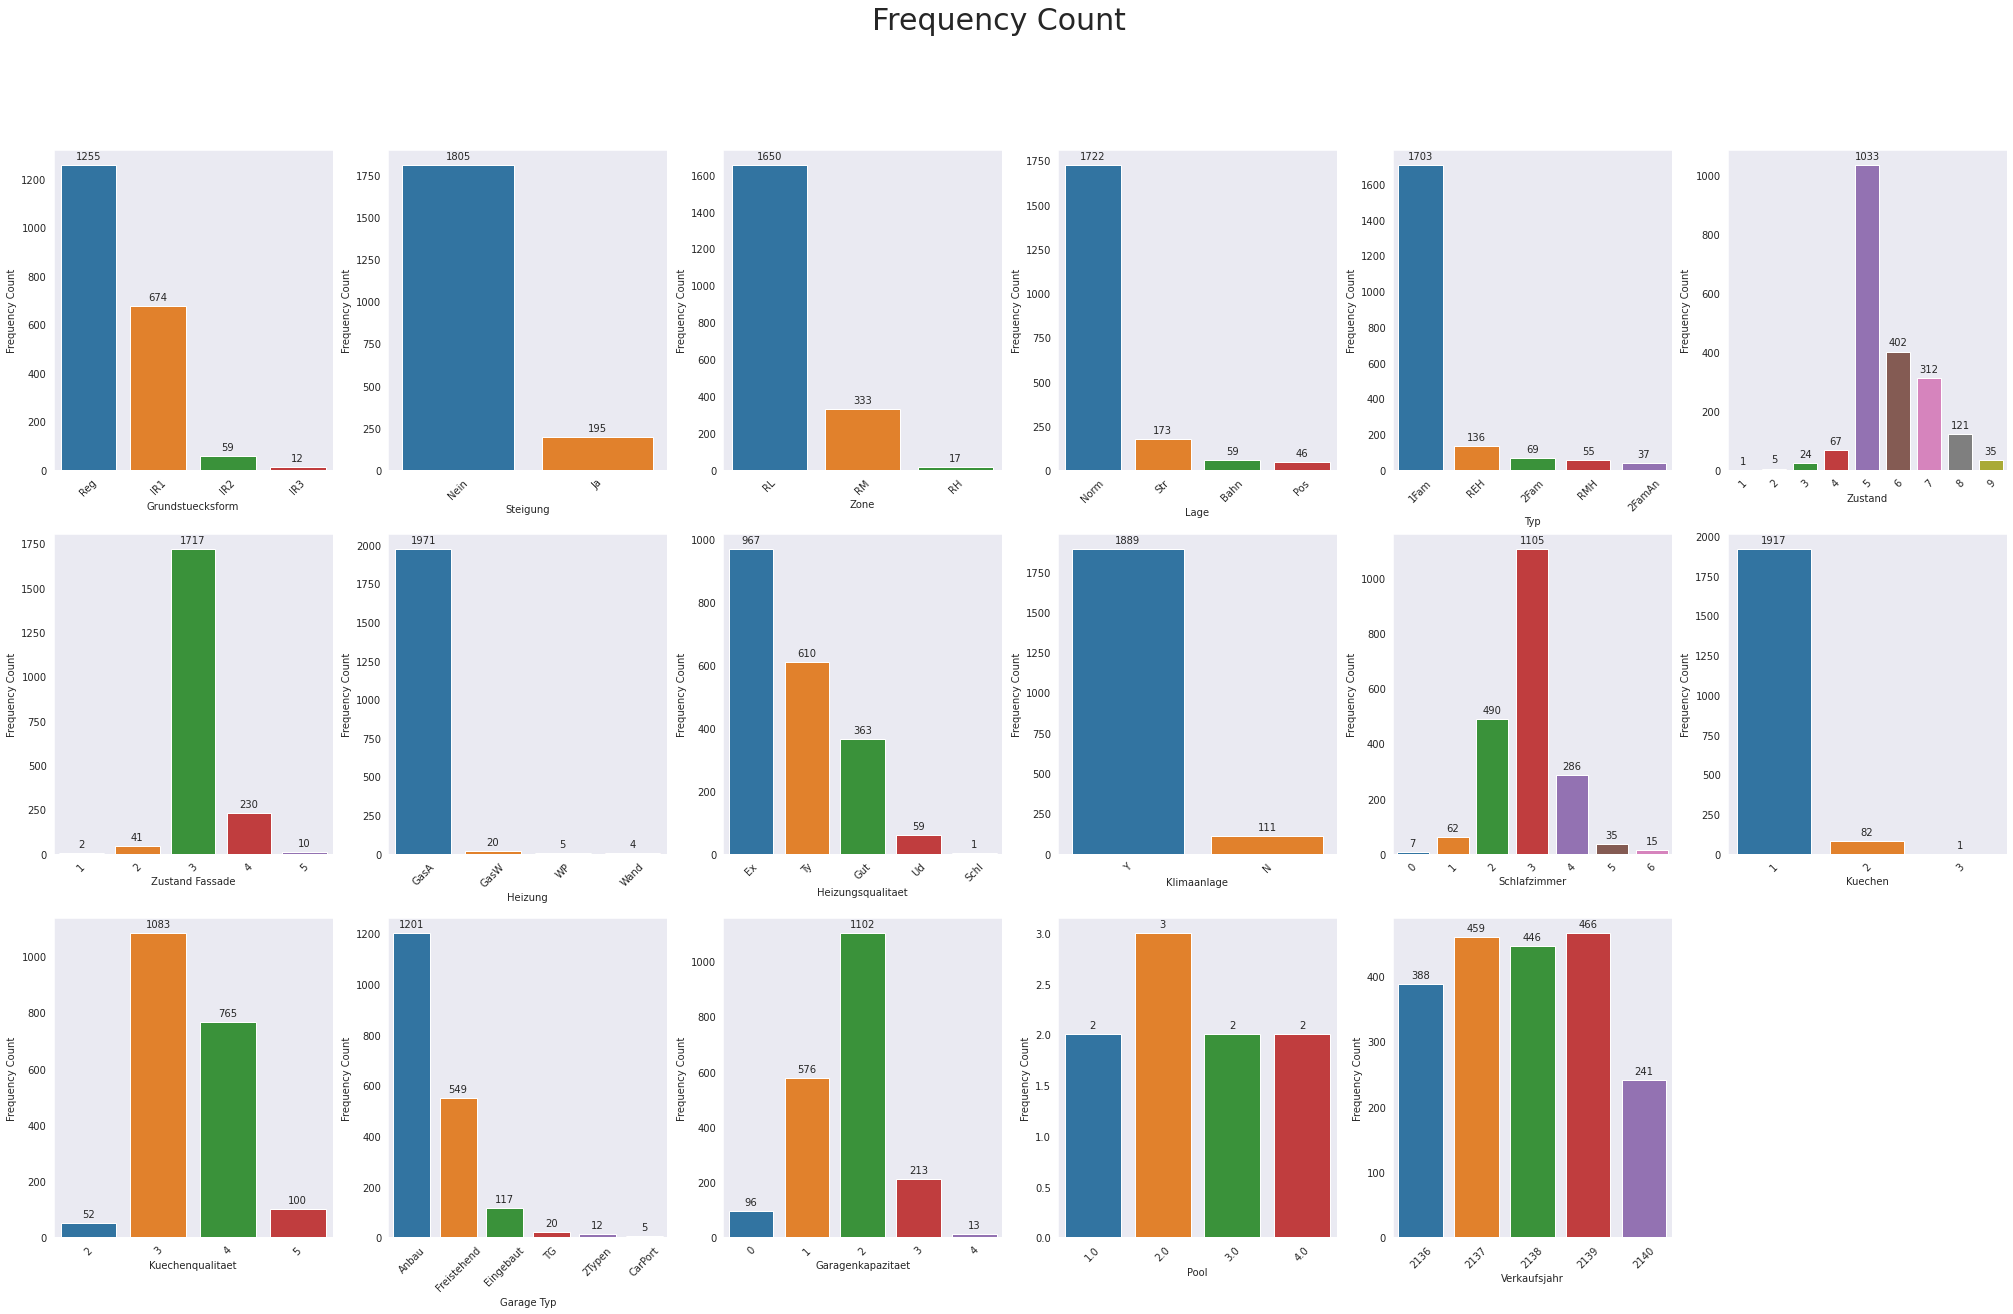

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(35,20))
fig.suptitle('Frequency Count', size=30)
# Flatten array for iteration purposes
ax = axs.flatten()
# Iterator
i = 0

for col in data:
  # Skip large columns
  if data[col].value_counts().size < 10:
    df = data[col].value_counts().to_frame().reset_index()
    sns.barplot(x='index', y=col, data=df, orient='v', ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Frequency Count')
    ax[i].tick_params('x', labelrotation=45)
    # Add values to bars
    for p in ax[i].patches:
      ax[i].annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    # Increment
    i = i+1

# Remove unused subplot (bottom right)
fig.delaxes(axs[-1, -1])
fig.show()

## 3. Correlation Heat-map between all numeric columns

Zur Visualisierung der Korrelation wird unten gezeigte Heatmap eingesetzt. Hieran lassen sich korrelierende Werte im Bezug auf die Preisbildung ablesen. Erreicht ein Wert **1.0** beeinflusst er die Preisbildung positiv. 
Befindet der Wert sich hingegen näher an der **0**, hat die Korrelation nahezu keinen Einfluss auf die Preisbildung.
Erreicht ein Wert eine Näherung an **-1**, so beeinflusst dieser die Preisbildung negativ.

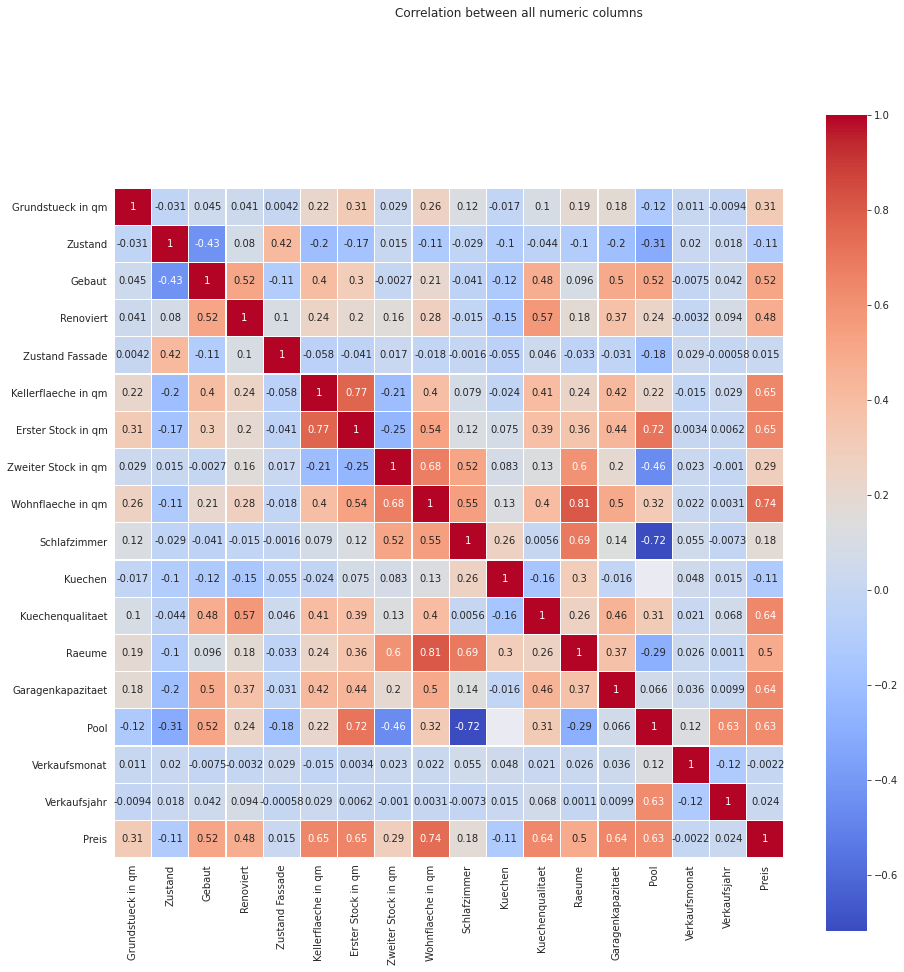

In [ ]:
fig, axs = plt.subplots(figsize=(15,15))

fig.suptitle('Correlation between all numeric columns')

sns.heatmap(data.select_dtypes(np.number).corr(method='pearson'), annot=True, cmap='coolwarm', linewidths=0.2, square=True, ax=axs)

plt.show()

Die oben stehende Heatmap hilft beim Verstehen der Featurekorrelation untereinander.  

*   Ein positives Vorzeichen impliziert eine positive Korrelation zwischen zwei Merkmalen, während ein negatives Vorzeichen eine negative Korrelation zwischen zwei Merkmalen impliziert. 
*   Wir wollen Merkmale finden, die eine gute Korrelation mit der abhängigen Variable **PREIS** aufweisen und zu guten Vorhersagen beitragen können.
*   Anhand der Heatmap entsteht unser Interesse an den Features **GEBAUT, RENOVIERT, KELLERFLÄCHE IN QM, ERSTER STOCK IN QM, WOHNFLÄCHE IN QM, KÜCHENQUALITÄT, RÄUME, GARAGENKAPAZITÄT** und **POOL**.
*   Da das Feature POOL jedoch ebenfalls hohe Korrelationen mit den Spalten **ERSTER STOCK IN QM** sowie **ZWEITER STOCK IN QM** aufweist, wird POOL aus diesem Grund, sowie der Tatsache von sehr vielen auftretenden NaN's aus der weiteren Analyse ausgeschlossen. Durch das Ausschließen von mehrfach korrelierenden Features wird der **Multikollinearität** vorgebeugt.   



In [ ]:
data1 = data[['Garagenkapazitaet','Raeume', 'Kuechenqualitaet', 'Wohnflaeche in qm', 'Erster Stock in qm', 'Kellerflaeche in qm' ,'Renoviert', 'Gebaut', 'Preis']]

data1

,Garagenkapazitaet,Raeume,Kuechenqualitaet,Wohnflaeche in qm,Erster Stock in qm,Kellerflaeche in qm,Renoviert,Gebaut,Preis
0,2,10,3,183,183,183,2107,2107,156500
1,3,7,4,222,113,122,2133,2133,350000
2,1,5,4,83,83,80,2138,2096,137900
3,2,8,4,157,83,83,2135,2135,184000
4,2,7,4,168,96,92,2129,2129,189000
...,...,...,...,...,...,...,...,...,...
1995,3,10,5,248,146,146,2134,2133,412500
1996,2,7,4,148,79,79,2134,2134,195500
1997,1,6,3,125,74,52,2130,2040,112000
1998,3,9,4,178,132,132,2134,2134,279000


In [ ]:
# Pairplot ziemlich unübersichtlich
# sns.pairplot(data=data1)

In [ ]:
desc = data1.describe().round(2)

desc

,Garagenkapazitaet,Raeume,Kuechenqualitaet,Wohnflaeche in qm,Erster Stock in qm,Kellerflaeche in qm,Renoviert,Gebaut,Preis
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1.74,6.40,3.46,137.99,106.48,96.14,2113.34,2099.03,176791.81
std,0.74,1.52,0.63,45.57,34.41,38.25,20.17,29.12,72060.41
min,0.00,2.00,2.00,31.00,31.00,0.00,2080.00,2005.00,39300.00
25%,1.00,5.00,3.00,102.00,82.00,74.00,2095.00,2083.00,130000.00
50%,2.00,6.00,3.00,133.00,99.00,91.00,2121.00,2101.00,158225.00
75%,2.00,7.00,4.00,161.00,126.00,117.00,2132.00,2126.00,207000.00
max,4.00,13.00,5.00,401.00,355.00,298.00,2140.00,2140.00,755000.00


## 4. Variance

Unter Verwendung von Boxplots lassen sich Wertansammlungen, Minima, Maxima sowie Durchschnitte leicht visuell darstellen. Aufgrund hohen Aufkommens werden später die Aureißer entfernt.

```
from scipy import stats

z = np.abs(stats.zscore(var_df))
```

Sollte die in den Settings hinterlegte Threshold unterschritten werden, wird die zugehörige Spalte aus dem Datensatz gelöscht.

```
(z < remove_outliers_threshold).all(axis=1)
```






## 4.1 Preis

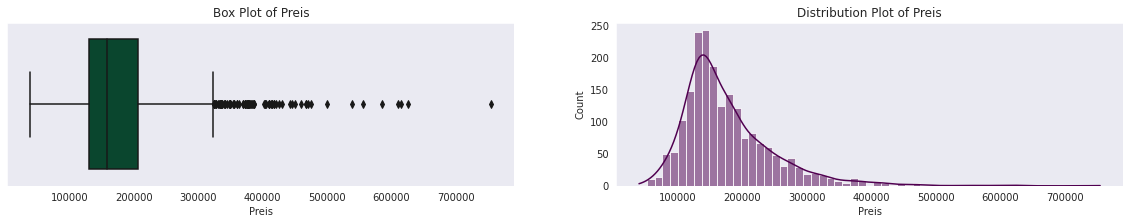

In [ ]:
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.boxplot(x=data1.Preis,color='#005030')
plt.title(f'Box Plot of Preis')

plt.subplot(1,2,2)
sns.histplot(data=data1.Preis, color='#500050', kde=True)
plt.title(f'Distribution Plot of Preis')
plt.show()

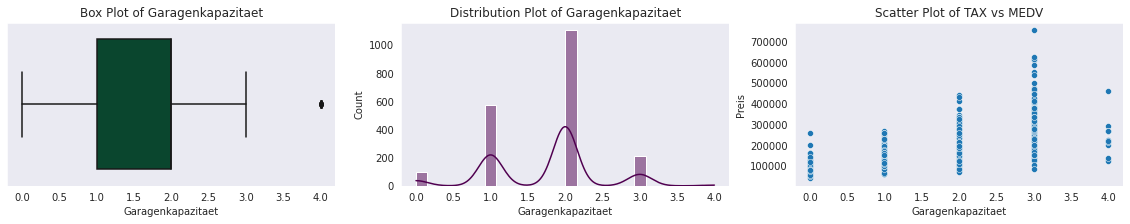

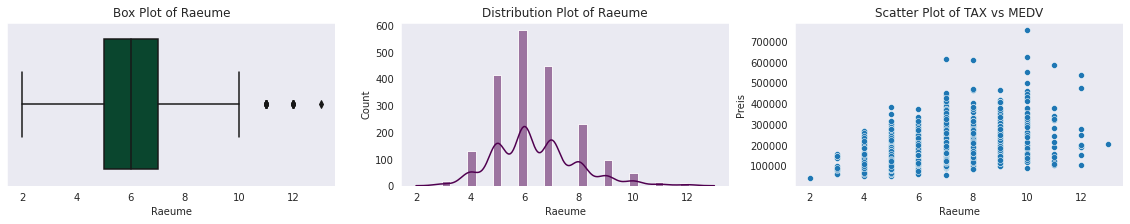

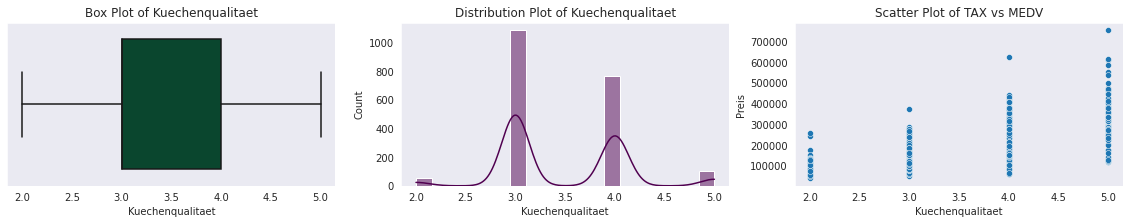

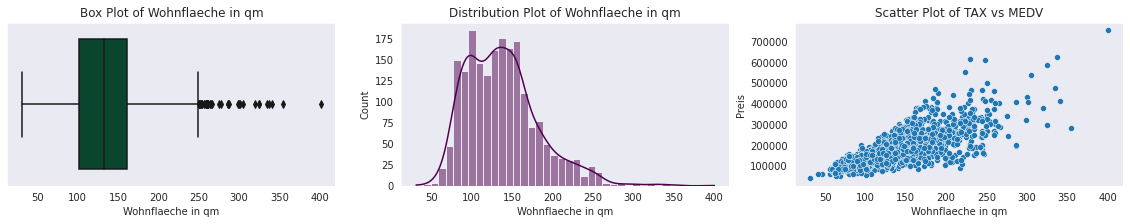

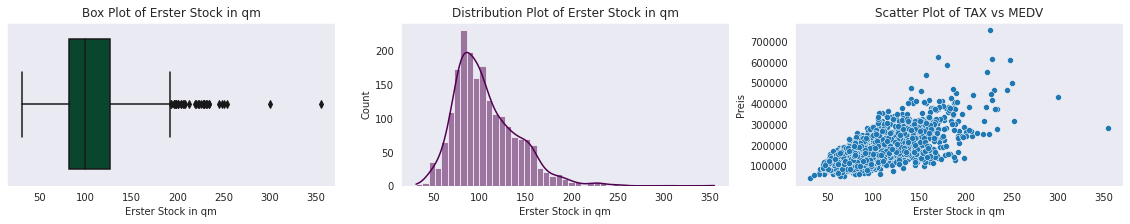

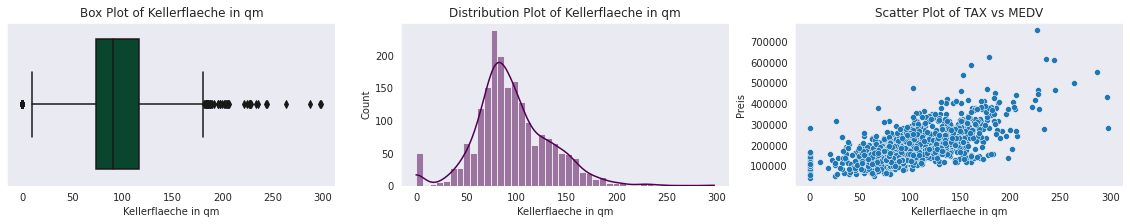

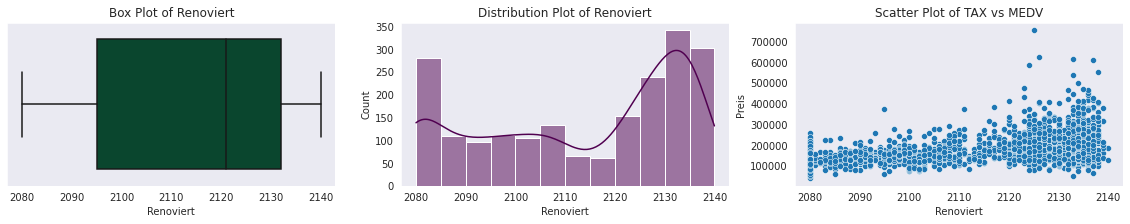

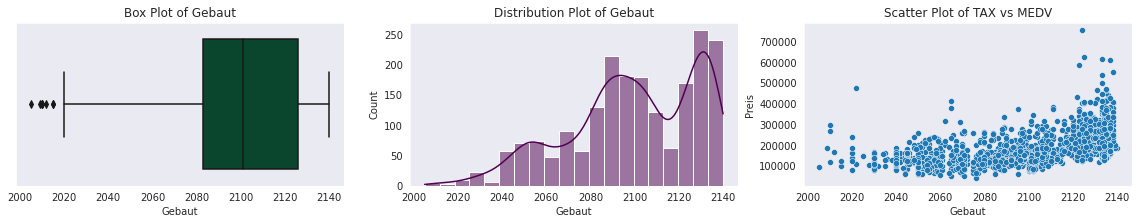

In [ ]:
# Analyze price

for entry in data1.drop(labels='Preis', axis=1): 
  plt.figure(figsize=(20,3))

  plt.subplot(1,3,1)
  sns.boxplot(x=data1[entry],color='#005030')
  plt.title(f'Box Plot of {entry}')

  plt.subplot(1,3,2)
  sns.histplot(data=data1[entry], color='#500050', kde=True)
  plt.title(f'Distribution Plot of {entry}')

  plt.subplot(1,3,3)
  sns.scatterplot(x=data1[entry],y=data1.Preis)
  plt.title('Scatter Plot of TAX vs MEDV')
  
  plt.show()

In oben stehender Analyse lassen sich die folgenden Aussagen ablesen:

*   Enthält teils extreme Werte, die potentiell als Ausreißer angesehen werden können
*   PREIS ist Normalverteilt



## 5. Pareto Analysis

Die Pareto Analyse wird für die Darstellung der kumulierten Preisverteilung verwendet. Hieran lässt sich beispielsweise ablesen, in welchem Preissegment sich 80% der angebotenen Häuser befinden.

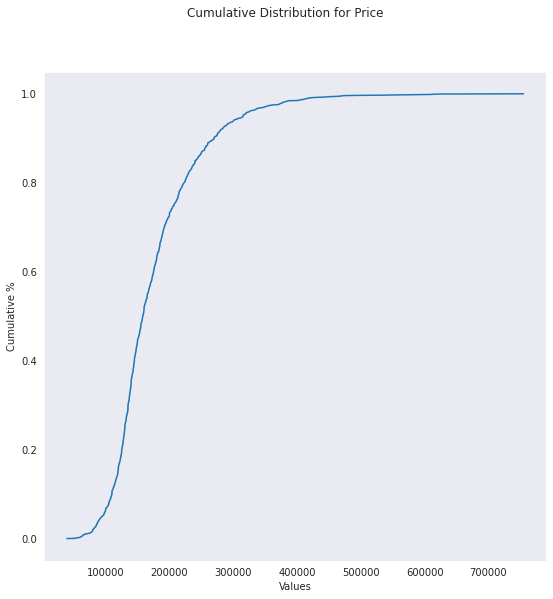

In [ ]:
# X contains all price values sorted
X = np.sort(data1['Preis'])
y = 1. * np.arange(len(data1['Preis'])) / (len(data1['Preis']) - 1)

fig, axs = plt.subplots(figsize=(9,9))
fig.suptitle('Cumulative Distribution for Price ')
sns.lineplot(x=X, y=y, ax=axs)
axs.set_xlabel('Values')
axs.set_ylabel('Cumulative %')
fig.show()

## 6. Cramer-V correlation between all Categorical columns

Bisher wurden nur die numerischen Features behandelt - Nun werden die kategorischen Features betrachtet.

Die Spalten werden nur hierfür faktorisiert. Im späteren Ablauf werden die eigentlichen kategorischen Daten richtig encodet.

In [ ]:
data2 = data.select_dtypes(include=np.object)

data2 = data2.apply(lambda entry: pd.factorize(entry)[0])

data2.insert(len(data2.columns), "Preis", data.Preis, True)

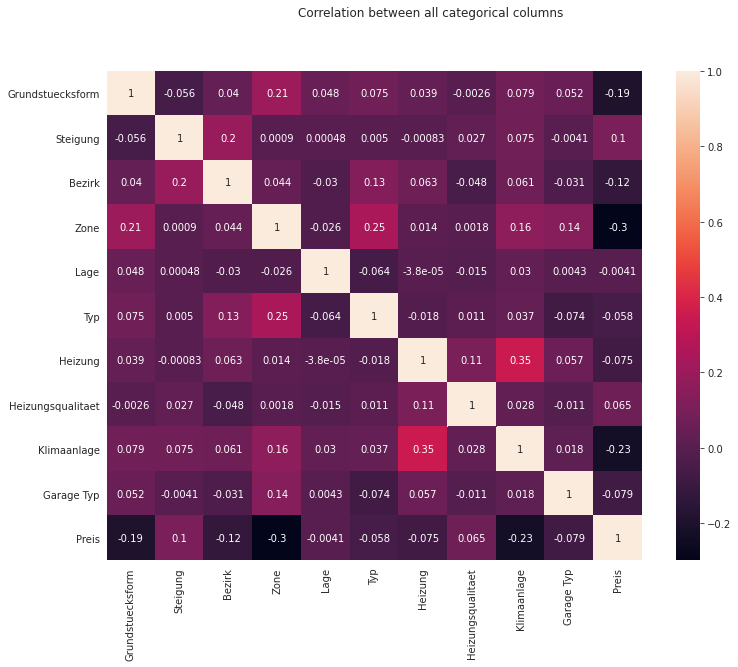

In [ ]:
fig, axs = plt.subplots(figsize=(12,9))

fig.suptitle('Correlation between all categorical columns')

sns.heatmap(data2.corr(), ax=axs, annot=True)

plt.show()

In [ ]:
# Concatenate datasets again

print(data2.drop('Preis', axis=1).shape)

print(data1.shape)

data3 = pd.concat([data.select_dtypes(include=np.object), data1], axis=1, sort=False)

data3

(2000, 10)
(2000, 9)


,Grundstuecksform,Steigung,Bezirk,Zone,Lage,Typ,Heizung,Heizungsqualitaet,Klimaanlage,Garage Typ,Garagenkapazitaet,Raeume,Kuechenqualitaet,Wohnflaeche in qm,Erster Stock in qm,Kellerflaeche in qm,Renoviert,Gebaut,Preis
0,IR1,Nein,Somerset,RL,Norm,2Fam,GasA,Ty,Y,Anbau,2,10,3,183,183,183,2107,2107,156500
1,Reg,Nein,North East,RL,Norm,1Fam,GasA,Ex,Y,Anbau,3,7,4,222,113,122,2133,2133,350000
2,Reg,Nein,Somerset,RL,Norm,1Fam,GasA,Ex,Y,Freistehend,1,5,4,83,83,80,2138,2096,137900
3,Reg,Nein,Somerset West,RL,Norm,1Fam,GasA,Ex,Y,Anbau,2,8,4,157,83,83,2135,2135,184000
4,Reg,Nein,Miller,RL,Norm,1Fam,GasA,Gut,Y,Anbau,2,7,4,168,96,92,2129,2129,189000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,IR1,Nein,North East,RL,Norm,1Fam,GasA,Ex,Y,Eingebaut,3,10,5,248,146,146,2134,2133,412500
1996,IR1,Nein,Miller,RL,Norm,1Fam,GasA,Ex,Y,Anbau,2,7,4,148,79,79,2134,2134,195500
1997,Reg,Nein,Grand Park,RL,Norm,1Fam,GasA,Gut,N,Freistehend,1,6,3,125,74,52,2130,2040,112000
1998,IR1,Nein,North East,RL,Norm,1Fam,GasA,Ex,Y,Eingebaut,3,9,4,178,132,132,2134,2134,279000


# Data Preparation und Modeling

## Remove Outliers

In [ ]:
from scipy import stats

z = np.abs(stats.zscore(data3.select_dtypes(exclude=np.object)))

print(f'Shape of dataset before removing Outliers: {data3.shape}')

if remove_outliers_automatically:
  data4 = data3[(z < remove_outliers_threshold).all(axis=1)]
  print(f'Shape of dataset after removing Outliers: {data4.shape}')
else:
  data4 = data3
  print('Outlier Removal Disabled')


Shape of dataset before removing Outliers: (2000, 19)
Shape of dataset after removing Outliers: (1920, 19)


Um die Daten für die Regressionsanalyse vorzubereiten, sind weitere Schritte notwendig. Zunächst müssen Featurespalten mit *NaN* Werten ausfindig gemacht und bereinigt werden. Hierfür werden die am häufigsten vorkommenden Werte als *Füllwerte* verwendet. Anschließend müssen die Indizes des Datensatzes zurückgesetzt werden, damit keine *Lücken* in den Daten entstehen. 

In [ ]:
# Featrues mit NaN
data4.isna().sum()

Grundstuecksform        0
Steigung                0
Bezirk                  0
Zone                    0
Lage                    0
Typ                     0
Heizung                 0
Heizungsqualitaet       0
Klimaanlage             0
Garage Typ             94
Garagenkapazitaet       0
Raeume                  0
Kuechenqualitaet        0
Wohnflaeche in qm       0
Erster Stock in qm      0
Kellerflaeche in qm     0
Renoviert               0
Gebaut                  0
Preis                   0
dtype: int64

In [ ]:
# Dem zuvor herausgefundenen Feature GarageTyp müssen die NaN's entfernt werden
data4['Garage Typ'].fillna(data4['Garage Typ'].value_counts().index[0], inplace=True)

# # Reset Index
data4 = data4.reset_index(drop=True)

data4.shape

(1920, 19)

Unterteilung der Daten in


*   X: Beeinflussende 
*   Y: Zielwert (Target-Value)

Verwendung des OneHot Encoding Verfahrens zur Transformation aller kategorischer Spalten in numerische Features. Dies ist notwendig, da das Regressionsverfahren nur mit numerischen Features rechnen kann.


In [ ]:
X = data4.iloc[:, :-1]
# X = X.select_dtypes(exclude=['object'])
y = data4.iloc[:, -1]

# Dimensionsprüfung
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

assert(X.shape == (1920,18))
assert(y.shape == (1920,))

Shape of X:  (1920, 18)
Shape of y:  (1920,)


In [ ]:
cols = data4.select_dtypes(include=np.object).columns

In [ ]:
# Neuen DataFrame erstellen unter Verwendung des OneHotEncoders auf kategorische Zeilen
from sklearn.preprocessing import OneHotEncoder

for col in cols:
  if col in data4:
    encoder = OneHotEncoder()
    X = data4[col]
    X = X.values.reshape(-1,1)

    tmp = data4.drop(col, axis=1)

    data4 = pd.concat([tmp, pd.DataFrame(encoder.fit_transform(X).toarray(), columns=encoder.get_feature_names())], axis=1)

    #df = pd.concat([data, pd.get_dummies(data.Heizung)], axis=1)

data4

,Garagenkapazitaet,Raeume,Kuechenqualitaet,Wohnflaeche in qm,Erster Stock in qm,Kellerflaeche in qm,Renoviert,Gebaut,Preis,x0_IR1,x0_IR2,x0_IR3,x0_Reg,x0_Ja,x0_Nein,x0_Burnley,x0_ChinaTown,x0_City Hall,x0_Clear Creek,x0_DiamondDistrict,x0_Dixon Side,x0_East End,x0_Fashion District,x0_Grand Park,x0_Miller,x0_New Gotham,x0_North East,x0_North West,x0_Novick District,x0_Old Gotham,x0_Paris Island,x0_Robinson Park,x0_Somerset,x0_Somerset West,x0_Somerst,x0_The Bowery,x0_Tricorner,x0_University,x0_Upper West,x0_Water District,x0_RH,x0_RL,x0_RM,x0_Bahn,x0_Norm,x0_Pos,x0_Str,x0_1Fam,x0_2Fam,x0_2FamAn,x0_REH,x0_RMH,x0_GasA,x0_GasW,x0_WP,x0_Wand,x0_Ex,x0_Gut,x0_Schl,x0_Ty,x0_Ud,x0_N,x0_Y,x0_2Typen,x0_Anbau,x0_CarPort,x0_Eingebaut,x0_Freistehend,x0_TG
0,2,10,3,183,183,183,2107,2107,156500,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,7,4,222,113,122,2133,2133,350000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,5,4,83,83,80,2138,2096,137900,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,8,4,157,83,83,2135,2135,184000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2,7,4,168,96,92,2129,2129,189000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1,4,3,62,62,62,2127,2070,108000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1916,2,7,4,148,79,79,2134,2134,195500,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1917,1,6,3,125,74,52,2130,2040,112000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1918,3,9,4,178,132,132,2134,2134,279000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# y -> Target Variable / Dependent Variable
y = data4['Preis']
#
data5 = data4.drop('Preis', axis = 1)
# X -> Independent Variables
X = data5.iloc[:,:]
# Sichterstellen dass keine Object Spalten mehr vorhanden sind
X = X.select_dtypes(exclude=['object'])

print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)

assert(y.name == 'Preis')

Shape of X:  (1920, 68)
Shape of y:  (1920,)


## Backward Elimination

Die Rückwärtige Eliminierung, bei der alle in Frage kommenden Variablen dazu verwendet werden, die Löschung einer jeden Variable anhand eines gewählten Modellanpassungskriteriums zu testen. Die Löschung wird nur dann ausgeführt, wenn deren Verlust die statistisch unbedeutendste Verschlechterung der Modellanpassung ergibt. Der Vorgang wird wiederholt, bis keine weiteren Variablen mehr gelöscht werden können, ohne dass ein statistisch unbedeutender Verlust der Anpassung auftritt.

In [ ]:
import statsmodels.api as sm

def BackwardElimination(sl, w):
    for i in range(0, len(w.columns)):
        regressor_OLS = sm.OLS(endog=list(y), exog=w).fit()
        max_pvalue = max(regressor_OLS.pvalues)
        pvalues = regressor_OLS.pvalues

        # print(regressor_OLS.summary())
        if max_pvalue > SL:
            index_max_pvalue = pvalues[pvalues==max_pvalue].index
            w = w.drop(index_max_pvalue, axis = 1) 
    return w,pvalues,index_max_pvalue

In [ ]:
if activate_backward_elimination:
  SL = 0.05
  ones = np.ones((len(X.index),1))
  W = X
  W.insert(0, 'Constant', ones, True)
  W_optimal = W.iloc[:, 0:len(W.columns)]

  W_optimal,pvalues,index_max_pvalue = BackwardElimination(SL, W_optimal)
  X = W_optimal.drop('Constant', axis=1)
  # X = W_optimal
else:
  print('Backward Elimination deactivated')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ',  X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

assert(y_train.name == 'Preis')
assert(y_test.name == 'Preis')

Shape of X_train:  (1536, 61)
Shape of X_test:  (384, 61)
Shape of y_train:  (1536,)
Shape of y_test:  (384,)


# Modeling: Preisvorhersage mit Hilfe von verschiedenen Regressionen

$ Y=f(x)+\epsilon $

$ Preis = f(X0, X1, X2, X3, ...) + \epsilon $

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, explained_variance_score, median_absolute_error, r2_score, mean_tweedie_deviance

def print_analyze(y_pred, y_test):
  return (pd.DataFrame({
      'R²': [r2_score(y_test, y_pred)],
      'MSE': [mean_squared_error(y_test,y_pred)], 
      'RMSE': [mean_squared_error(y_test,y_pred, squared=False)],
      'MAPE': [mean_absolute_percentage_error(y_test,y_pred)],
      'MAXERROR': [max_error(y_test, y_pred)],
      'MEDIANAE': [median_absolute_error(y_test, y_pred)],
      'EVS': [explained_variance_score(y_test, y_pred)],
      'MEANAE': [mean_absolute_error(y_test,y_pred)]
      }))
  
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_regression_score(reg):
  print('Regression Model:', type(reg).__name__)
  print('Train Score: \t', reg.score(X_train, y_train))
  print('Test Score: \t', reg.score(X_test, y_test))
  print('Difference: \t', reg.score(X_train, y_train) - reg.score(X_test, y_test) )

In [ ]:
from sklearn.linear_model import LinearRegression

# Create Regression Model
linear = LinearRegression()
# Fit the data into the model
linear.fit(X_train, y_train)
# Predict target values
y_pred = linear.predict(X_test)
y_compare_linear = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_compare_linear.head()

print_analyze(y_pred, y_test)

,R²,MSE,RMSE,MAPE,MAXERROR,MEDIANAE,EVS,MEANAE
0,0.87497,4.374255e+08,20914.720749,9.922254,79600.289151,11718.438624,0.875051,15521.830025


In [ ]:
print_regression_score(linear)

Regression Model: LinearRegression
Train Score: 	 0.8777349711738558
Test Score: 	 0.8749701944164727
Difference: 	 0.0027647767573830695


In [ ]:
from sklearn.svm import SVR

# Create Regression Model
svr = SVR(kernel= 'linear', gamma='scale')
# Fit the data into the model
svr.fit(X_train,y_train)
# Predict target values
y_pred = svr.predict(X_test)
y_compare_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_compare_svr.head()

print_analyze(y_pred, y_test)

,R²,MSE,RMSE,MAPE,MAXERROR,MEDIANAE,EVS,MEANAE
0,0.797273,7.092552e+08,26631.845306,12.03311,111443.959004,13235.619268,0.797289,18978.931298


In [ ]:
print_regression_score(svr)

Regression Model: SVR
Train Score: 	 0.7611583692010214
Test Score: 	 0.797272840989479
Difference: 	 -0.036114471788457614


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create Regression Model
rf = RandomForestRegressor(n_estimators=100)
# Fit the data into the model
rf.fit(X_train,y_train)
# Predict target values
y_pred = rf.predict(X_test)
y_compare_randomforrest = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_compare_randomforrest.head()

print_analyze(y_pred, y_test)

,R²,MSE,RMSE,MAPE,MAXERROR,MEDIANAE,EVS,MEANAE
0,0.88584,3.993985e+08,19984.956206,8.975477,98470.0,10429.25,0.88659,13896.017931


In [ ]:
print_regression_score(rf)

Regression Model: RandomForestRegressor
Train Score: 	 0.9809590994451826
Test Score: 	 0.8858395118664449
Difference: 	 0.09511958757873762


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Create Regression Model
knn = KNeighborsRegressor(n_neighbors=13)
# Fit the data into the model
knn.fit(X_train,y_train)
# Predict target values
y_pred = knn.predict(X_test)
y_compare_knn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_compare_knn.head() 

print_analyze(y_pred, y_test)

,R²,MSE,RMSE,MAPE,MAXERROR,MEDIANAE,EVS,MEANAE
0,0.852019,5.177226e+08,22753.517319,10.912043,93019.230769,11873.076923,0.853661,16649.207131


In [ ]:
print_regression_score(knn)

Regression Model: KNeighborsRegressor
Train Score: 	 0.8365070243243978
Test Score: 	 0.8520188162108581
Difference: 	 -0.015511791886460236


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regression Model
gbr = GradientBoostingRegressor(loss='huber')
# Fit the data into the model
gbr.fit(X_train, y_train)
# Predict target values
y_pred = gbr.predict(X_test)
y_compare_gbr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
y_compare_gbr.head()

print_analyze(y_pred, y_test)

,R²,MSE,RMSE,MAPE,MAXERROR,MEDIANAE,EVS,MEANAE
0,0.895682,3.649624e+08,19103.988515,8.848895,72411.134107,9306.802915,0.89586,13500.840925


In [ ]:
print_regression_score(gbr)

Regression Model: GradientBoostingRegressor
Train Score: 	 0.9173244252961066
Test Score: 	 0.8956824179819112
Difference: 	 0.02164200731419541


In [ ]:
def plot_reg(axis, y_compare, title='', least_squares=False):

  from scipy.stats import linregress
  slope, intercept, r_value, p_value, std_err = linregress(y_compare['Actual'], y_compare['Predicted'])

  sns.scatterplot(x=y_compare['Actual'], y=y_compare['Predicted'], ax=axis)
  if least_squares: axis.plot([0, y_test.max()], [intercept, intercept + y_test.max()*slope], c='red')
  if title != '': axis.title.set_text(title)

# Evaluation: Vergleich der Regressionsmodelle

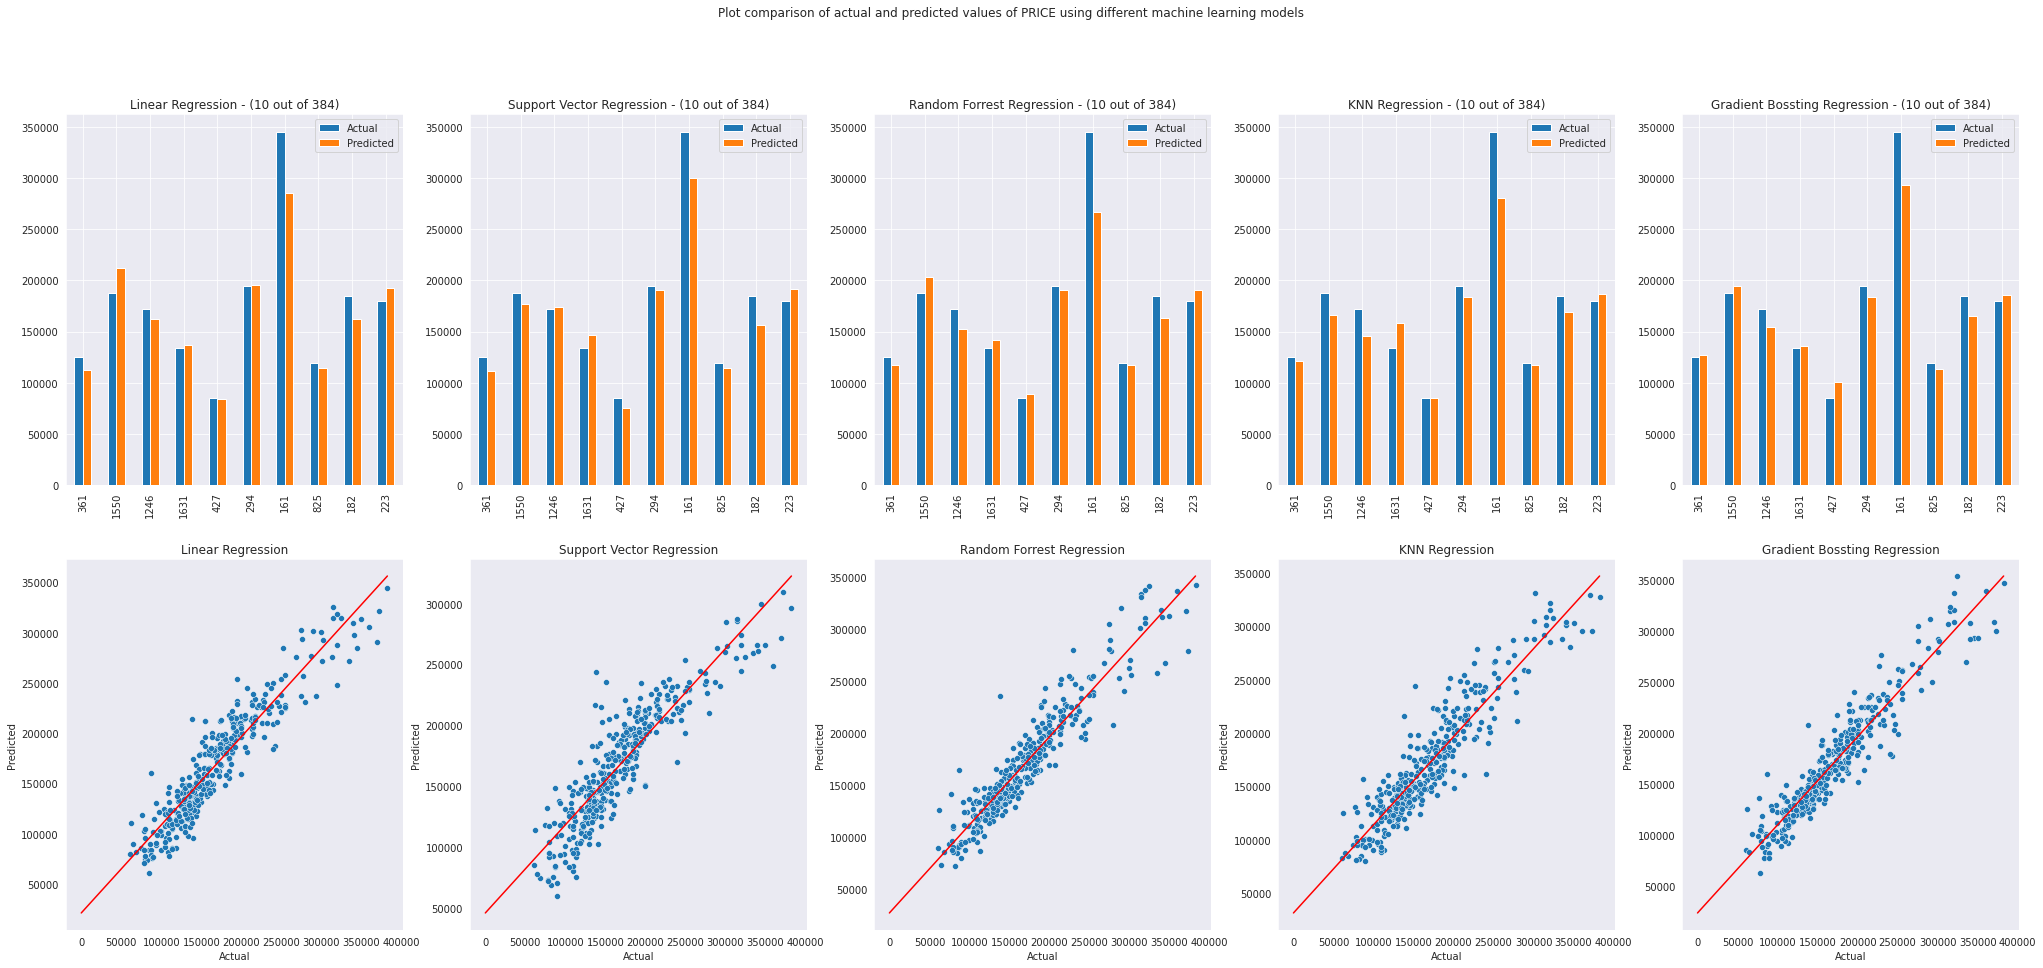

In [ ]:
bins = 10 

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(35, 15))
fig.suptitle('Plot comparison of actual and predicted values of PRICE using different machine learning models')

ax = ax.flatten()
y_compare_linear.head(bins).plot(kind='bar', title=('Linear Regression - (%d out of %d)' % (bins, y_compare_linear.size / 2)), grid=True, ax=ax[0])
y_compare_svr.head(bins).plot(kind='bar', title=('Support Vector Regression - (%d out of %d)' % (bins, y_compare_svr.size / 2)), grid=True, ax=ax[1])
y_compare_randomforrest.head(bins).plot(kind='bar', title=('Random Forrest Regression - (%d out of %d)' % (bins, y_compare_randomforrest.size / 2)), grid=True, ax=ax[2])
y_compare_knn.head(bins).plot(kind='bar', title=('KNN Regression - (%d out of %d)' % (bins, y_compare_knn.size / 2)), grid=True, ax=ax[3])
y_compare_gbr.head(bins).plot(kind='bar', title=('Gradient Bossting Regression - (%d out of %d)' % (bins, y_compare_gbr.size / 2)), grid=True, ax=ax[4])
plot_reg(ax[5], y_compare_linear, title='Linear Regression', least_squares=True)
plot_reg(ax[6], y_compare_svr, title='Support Vector Regression', least_squares=True)
plot_reg(ax[7], y_compare_randomforrest, title='Random Forrest Regression', least_squares=True)
plot_reg(ax[8], y_compare_knn, title='KNN Regression', least_squares=True)
plot_reg(ax[9], y_compare_gbr, title='Gradient Bossting Regression', least_squares=True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score as cvs

print('According to R squared scorring method we got below scores for our machine learning models:')
modelNames = ['Linear','Support Vector', 'Random Forrest', 'K-Nearest Neighbour', 'Gradient Boosting']
modelRegressors = [linear, svr, rf, knn, gbr]
models = pd.DataFrame({'modelNames' : modelNames, 'modelRegressors' : modelRegressors})
counter=0
score=[]
for i in models['modelRegressors']:
  accuracy = cvs(i, X_train, y_train, scoring='r2', cv=5)
  # Print the Accuracy of the model with +/- standard deviation
  print('Accuracy of %s Regression model is %.2f (+/- %0.2f)' %(models.iloc[counter,0],accuracy.mean(), accuracy.std()))
  score.append(accuracy.mean())
  counter+=1

According to R squared scorring method we got below scores for our machine learning models:
Accuracy of Linear Regression model is 0.87 (+/- 0.01)
Accuracy of Support Vector Regression model is 0.76 (+/- 0.02)
Accuracy of Random Forrest Regression model is 0.86 (+/- 0.02)
Accuracy of K-Nearest Neighbour Regression model is 0.80 (+/- 0.02)
Accuracy of Gradient Boosting Regression model is 0.87 (+/- 0.02)


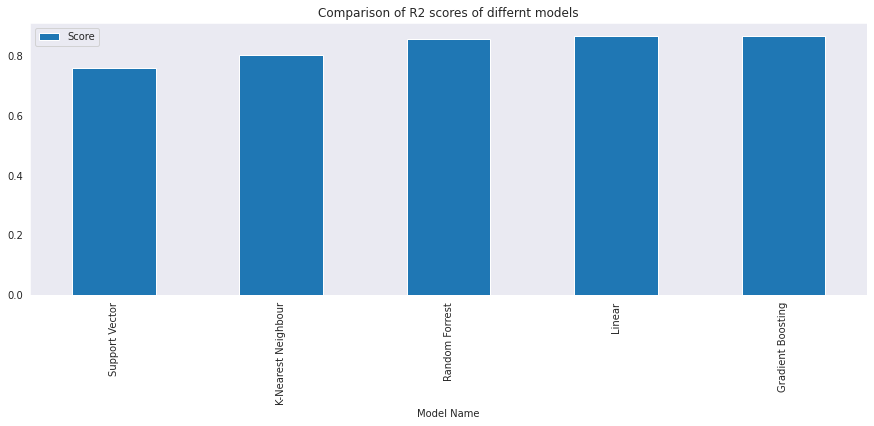

In [ ]:
pd.DataFrame({'Model Name' : modelNames,'Score' : score}).sort_values(by='Score', ascending=True).plot(x=0, y=1, kind='bar', figsize=(15,5), title='Comparison of R2 scores of differnt models', )
plt.show()

In [ ]:
# Create Lists
r2_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})
mse_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})
rmse_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})
maxerror_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})
mae_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})
evs_df = pd.DataFrame({'Linear': pd.DataFrame(),'Support Vector': [], 'Random Forrest': [], 'K-Nearest Neighbour': [], 'Gradient Boosting': []})

In [ ]:
# Crossvalidate all scoring methods

counter=0

for i in models['modelRegressors']:
  model = models.iloc[counter,0]
  r2_df[model] = cvs(i, X_train, y_train, scoring='r2', cv=5)
  mse_df[model] = cvs(i, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
  rmse_df[model] = cvs(i, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
  maxerror_df[model] = cvs(i, X_train, y_train, scoring='max_error', cv=5)
  mae_df[model] = cvs(i, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
  evs_df[model] = cvs(i, X_train, y_train, scoring='explained_variance', cv=5)
  counter+=1

In [ ]:
scores = [r2_df, mse_df, rmse_df, maxerror_df, mae_df, evs_df]
score_names = ['R2', 'MSE', 'RMSE', 'MAXERROR', 'MAE', 'EVS']

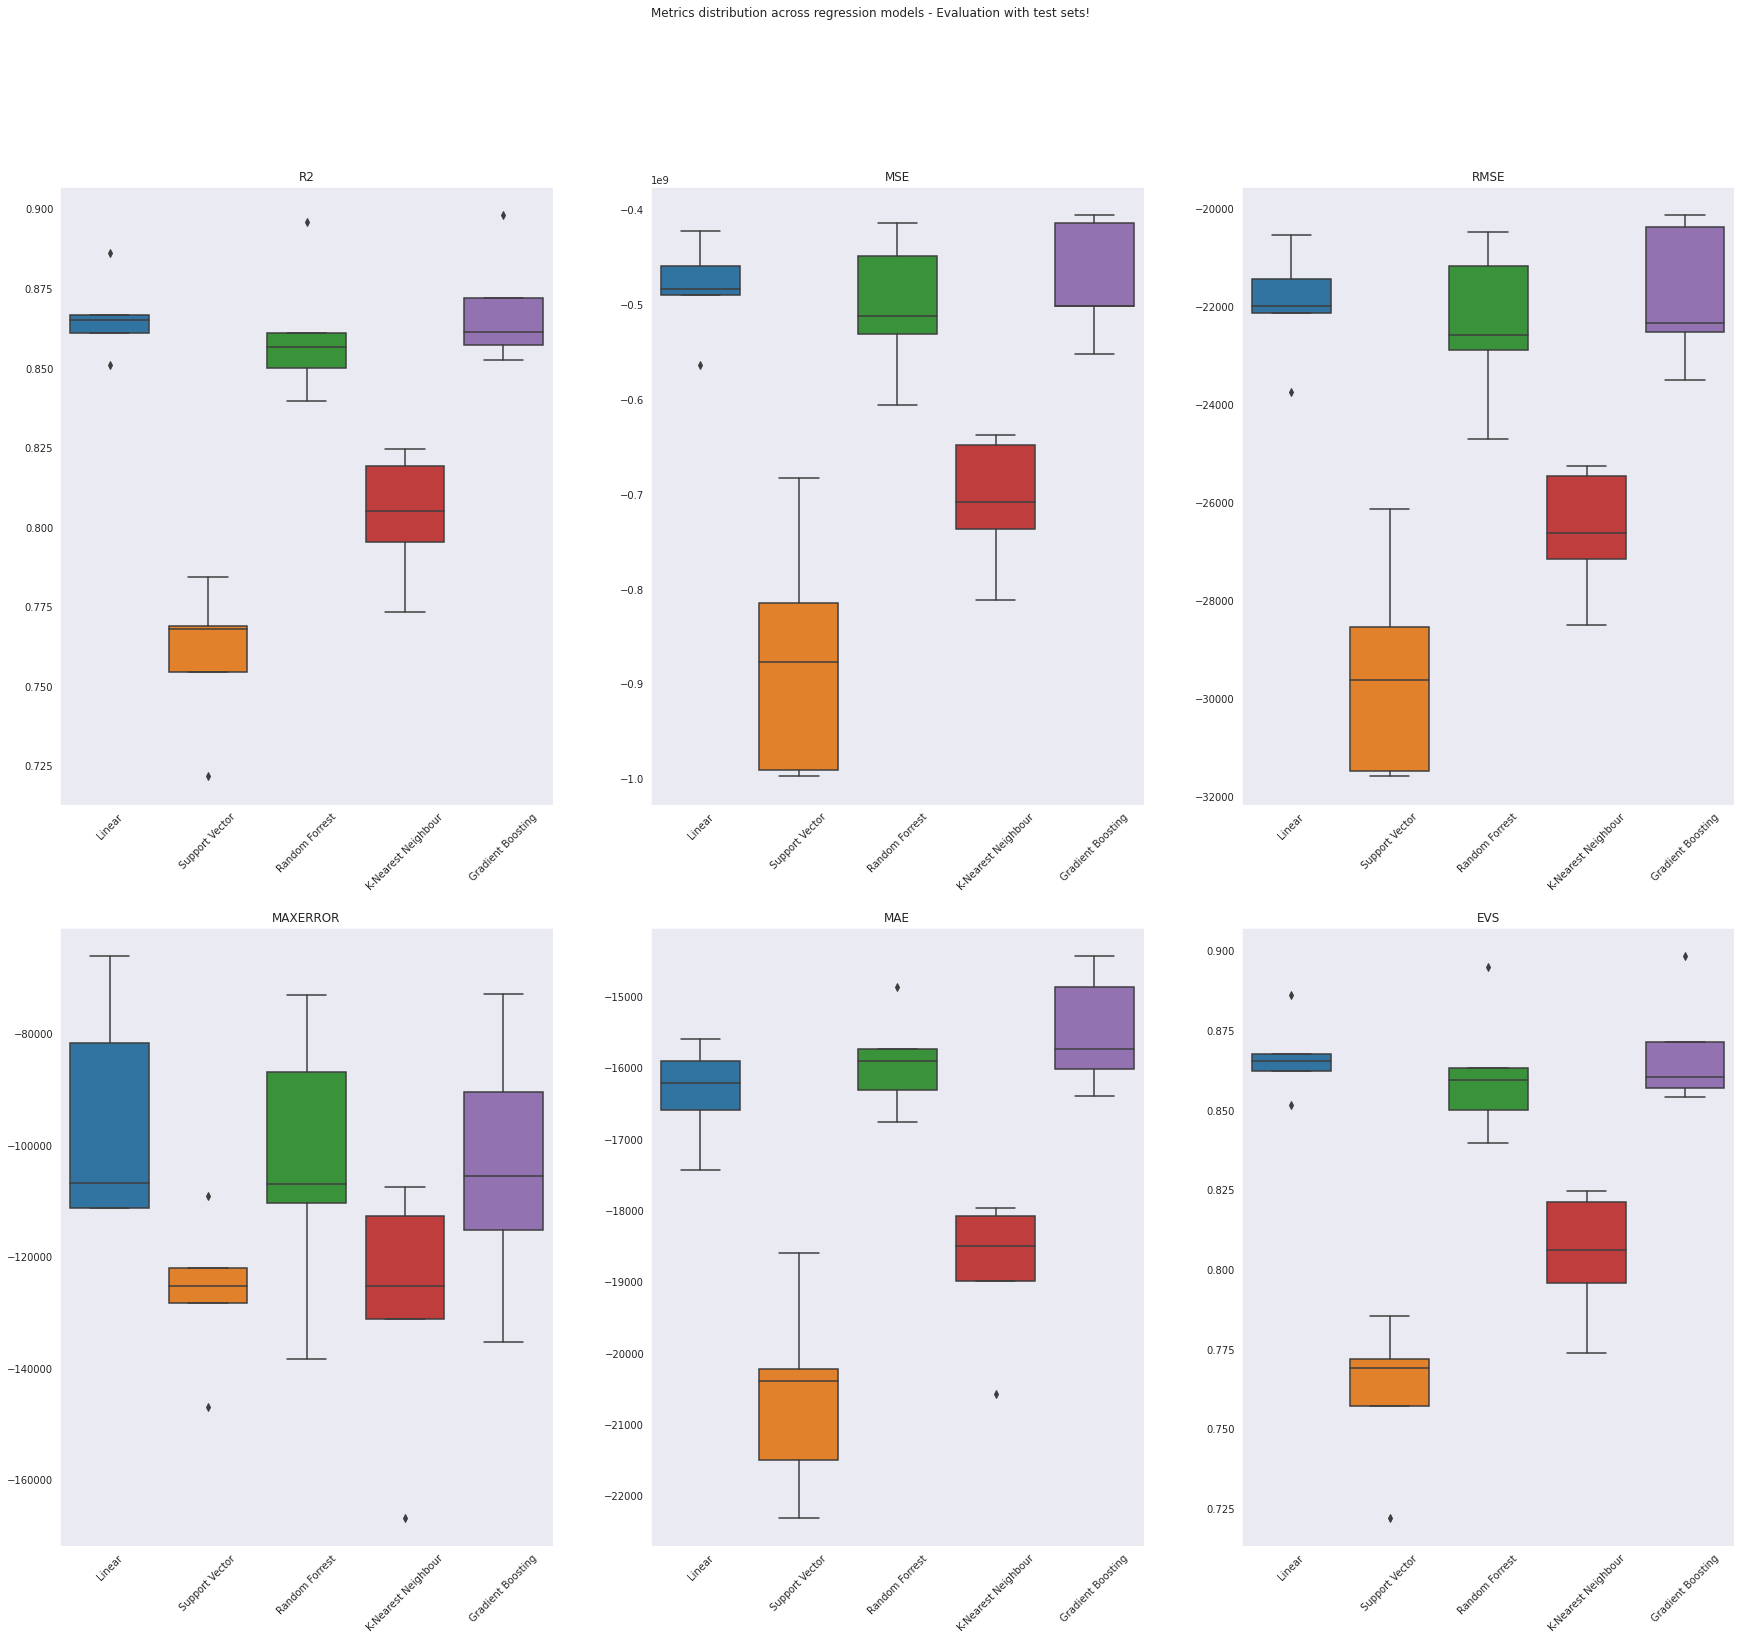

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 25))
ax = ax.flatten()

fig.suptitle('Metrics distribution across regression models - Evaluation with test sets!')

for i, sc in enumerate(scores):
  sns.boxplot(data=sc, ax=ax[i])
  ax[i].set_title(score_names[i])
  ax[i].tick_params('x', labelrotation=45)

# Werte sollen negativ sein!! Bei direkter Metrik Evaluation wird nur das Vorzeichen umgekehrt!